In [ ]:
import pandas as pd

# Read in raw data sets

In [ ]:
# The following csv-files provide the raw data we will use in this project

# orders.csv
orders = pd.read_csv('../data/raw/orders.csv')
# orderlines.csv
orderlines = pd.read_csv('../data/raw/orderlines.csv')
# products.csv
products = pd.read_csv('../data/raw/products.csv')
# brands.csv
brands = pd.read_csv('../data/raw/brands.csv')

**Starting data status (rows, columns)**<br>
<i>You can find the individual changes to the data cleaning process in the documentation in the folder ../docs</i>

orders: (226909, 4)<br>
orderlines:(293983, 7)<br>
products:(19326, 7)<br>
brands:(187, 2)<br>

# Exploring the data sets
<i>Note: I created a function that gives you all information about the data DataFrames

In [ ]:
#
# import sys
# import os
# Add the "scripts" directory relative to the notebook
# sys.path.append(os.path.abspath('../scripts'))
#

In [ ]:
import sys
import os
# Add the "scripts" directory absolute to the notebook
sys.path.append(os.path.abspath('../scripts'))
from data_overview import data_overview

In [ ]:
#
# import importlib
# import data_overview
# importlib.reload(data_overview)
# from data_overview import data_overview
#

In [ ]:
# Use function data_overview (change df_name for DataFrame)
data_overview(orders, df_name="orders")

# Cleaning of data sets

## Removal of duplicates

In [ ]:
# Creating copies if you like before start cleaning. I did not do so.
orders_c = orders.copy()
orderlines_c = orderlines.copy()
products_c = products.copy()
brands_c = brands.copy()

In [ ]:
# orders - no duplicates
orders.duplicated().sum()

In [ ]:
# orderlines - no duplicates
orderlines.duplicated().sum()

In [ ]:
# A very large amount of products are duplicated (8746, or 45%)
products.duplicated().sum()

In [ ]:
# Dropping duplicates
products.drop_duplicates(inplace=True)

In [ ]:
# Verifying duplicates have been removed
# Original number 19326 --> -8746 removed = updated number 10580
products.info()

In [ ]:
# brands - no duplicates
brands.info()

## Removal of missing values

In [ ]:
# orders missing 5 values. There is such a tiny amount of missing values (0.000022%)
orders.total_paid.isna().sum()

In [ ]:
# orders missing values removed
orders.dropna(subset=['total_paid'], inplace=True)
# Alternative: orders = orders.loc[~orders.total_paid.isna(), :]

In [ ]:
# orderlines has no missing values
orderlines.info()

In [ ]:
# products has 3 columns missing values
# 7 values are missing from the desc column
# 46 values are missing from the price column
# 50 values are missing from the type column -- !!!BUT we will not remove it and check it later again!!!
products.info()

In [ ]:
# Copying product names to the missing description values for the same row, in case we want to use the description column at some point.
# The 7 rows that previously had missing information for "desc" have not been deleted, because of the above copying step

products.loc[products['desc'].isna(), 'desc'] = products.loc[products['desc'].isna(), 'name']

In [ ]:
products.info()

In [ ]:
# Deleting price rows with missing values
products.dropna(subset=['price'], inplace=True)
# Alternative: products = products.loc[~products.price.isna(), :]

In [ ]:
# Check again for missing values in our 3 DataFrames
# orders[orders.isna().any(axis=1)]
orderlines[orderlines.isna().any(axis=1)]
# products[products.isna().any(axis=1)]

In [ ]:
products.info()

## Removal of two-dot problem (and column "promo_price")

### Removal from orderlines DataFrame

In [ ]:
# That gives you an value error: Unable to parse string "1.137.99" (two-dot problem)
orderlines["unit_price"] = pd.to_numeric(orderlines["unit_price"])

In [ ]:
# Check how many rows are affected by the problem
orderlines.unit_price.str.contains(r"\d+\.\d+\.\d+").value_counts() # > 36.169 rows are affected

In [ ]:
# Work out how much that is as a percentage of total data --> 12,3 %
two_dot_percentage = ((orderlines.unit_price.str.contains(r"\d+\.\d+\.\d+").value_counts().iloc[1] / orderlines.shape[0])*100).round(2)
print(f"The 2 dot problem represents {two_dot_percentage}% of the rows in our DataFrame")

In [ ]:
# Find the order numbers associated with the rows that have 2 decimal points, and then remove all the associated rows
two_dot_order_ids_list = orderlines.loc[orderlines.unit_price.str.contains(r"\d+\.\d+\.\d+"), "id_order"]
orderlines = orderlines.loc[~orderlines.id_order.isin(two_dot_order_ids_list)]
orderlines

In [ ]:
# After deleting there are 216250 rows without a two-dot problem
orderlines.shape[0]

### Removals from products DataFrame

In [ ]:
# Check if there are any other numbers like this:
products.price.str.contains(r"\d+\.\d+\.\d+").value_counts()

In [ ]:
# Looking at how many rows in products (column "price") have the two-dot problem = 542
price_problems_number = products.loc[(products.price.astype(str).str.contains(r"\d+\.\d+\.\d+"))|(products.price.astype(str).str.contains(r"\d+\.\d{3,}")), :].shape[0]
price_problems_number

In [ ]:
# Looking at how many rows in products (column "price") have the two-dot problem = 542
price_problems_number = products.loc[(products.price.astype(str).str.contains(r"\d+\.\d+\.\d+"))].shape[0]
price_problems_number

In [ ]:
# Removing the problem from products
products = products.loc[(~products.price.astype(str).str.contains(r"\d+\.\d+\.\d+"))&(~products.price.astype(str).str.contains(r"\d+\.\d{3,}")), :]

In [ ]:
# Original count was 10580 - 588 removed = 9992 now
products.info()

In [ ]:
# Looking at how many rows in products (column "promo_price") have the two-dot problem  = 9232
promo_problems_number = products.loc[(products.promo_price.astype(str).str.contains(r"\d+\.\d+\.\d+"))|(products.promo_price.astype(str).str.contains(r"\d+\.\d{3,}")), :].shape[0]
promo_problems_number

In [ ]:
# Over 90% of the values in promo_price are two-dotted
print(f"The column promo_price has in total {promo_problems_number} wrong values. This is {round(((promo_problems_number / products.shape[0]) * 100), 2)}% of the rows of the DataFrame")

In [ ]:
# As over 90% of the data in the column is corrupt, complete column will be deleted

# Completely deleting promo_price column
products = products.drop(columns=["promo_price"])

## Removal of unwanted order states

In [ ]:
# Making copies
o_df = orders.copy()
ol_df = orderlines.copy()
p_df = products.copy()
b_df = brands.copy()

In [ ]:
# Changing datatype
o_df["created_date"] = pd.to_datetime(o_df["created_date"])
ol_df["date"] = pd.to_datetime(ol_df["date"])

In [ ]:
# Checking count per 'state':

# 7233 rows are "cancelled" only
# o_df[o_df['state'].str.contains('cancelled', case=False, na=False)]

# 117809 rows are "shopping basket" only
# o_df[o_df['state'].str.contains('shopping basket', case=False, na=False)]

# 14374 rows are "pending" only
# o_df[o_df['state'].str.contains('pending', case=False, na=False)]

# 40883 rows are "place order" only
# o_df[o_df['state'].str.contains('place order', case=False, na=False)]

# 46605 rows are "completed" only
# o_df[o_df['state'].str.contains('completed', case=False, na=False)]

In [ ]:
# Keeping only rows with value "Completed" for column "state"
# Original number of rows before filtering: 226904
# Updated number of rows after filtering: 46605

o_df = o_df[o_df['state'] == 'Completed']

In [ ]:
o_df.shape

## Keeping only orders present in both orders and orderlines

In [ ]:
orders_orderlines = o_df.merge(ol_df,
                left_on ='order_id',
                right_on ='id_order',
                how ='inner')

In [ ]:
# 56714 = original number of rows before removing order_id rows missing from the products table
orders_orderlines.shape

In [ ]:
order_ids = orders_orderlines['order_id'].unique()

In [ ]:
# Keeping only the common order_ids in orders
o_df = o_df[o_df["order_id"].isin(order_ids)]

# Keeping only the common order_ids in orderlines
ol_df = ol_df[ol_df["id_order"].isin(order_ids)]

In [ ]:
# Orders and orderlines now have same amount of unique order_ids
o_df["order_id"].nunique(), ol_df["id_order"].nunique()

## Removal of unknown products

In [ ]:
orderlines_products = ol_df.merge(p_df, how="left", on = "sku")[["id_order","sku","name" ]]
orderlines_products.sample(10)

In [ ]:
orders_to_delete = orderlines_products.loc[orderlines_products.name.isna(), "id_order"].unique()
orders_to_delete

In [ ]:
# Keeping only the orders in orders that are not corrupted
o_df = o_df.loc[~o_df.order_id.isin(orders_to_delete),:]

In [ ]:
# Keeping only the orders in orderlines that are not corrupted
ol_df = ol_df.loc[~ol_df.id_order.isin(orders_to_delete),:]

In [ ]:
o_df["order_id"].nunique(), ol_df["id_order"].nunique()

## Removal of outliers

In [ ]:
ol_agg_o.info()

In [ ]:
ol_df["unit_price"] = pd.to_numeric(ol_df["unit_price"])

In [ ]:
# Creating a new column with values of the other two tables multiplied
ol_df['unit_price_total'] = ol_df['unit_price'] * ol_df['product_quantity']

In [ ]:
ol_agg = ol_df.groupby("id_order", as_index=False)["unit_price_total"].sum()

In [ ]:
ol_agg_o = ol_agg.merge(o_df, left_on="id_order", right_on="order_id")

In [ ]:
ol_agg_o_dif = ol_agg_o.copy()

In [ ]:
ol_df["unit_price_total"] = pd.to_numeric(ol_df["unit_price_total"])

In [ ]:
# Difference between total_paid and unit_price_total
ol_agg_o_dif["order_price_dif"] = ol_agg_o["total_paid"] - ol_agg_o["unit_price_total"]

In [ ]:
# Removing outliers from ol_agg_o_diff (orderlines aggregated and merged with orders, dif between total_price and unit_price_total)

# Calculating Q1 (25th percentile) and Q3 (75th percentile)
Q1 = ol_agg_o_dif["order_price_dif"].quantile(0.25)
Q3 = ol_agg_o_dif["order_price_dif"].quantile(0.75)
IQR = Q3 - Q1

# Defining the outlier range
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filtering the DataFrame to remove outliers
ol_agg_o_dif_no_outliers = ol_agg_o_dif[(ol_agg_o_dif["order_price_dif"] >= lower_bound) & (ol_agg_o_dif["order_price_dif"] <= upper_bound)]

In [ ]:
# Removing the outliers' unique order_id/id_order from orders as well as from orderlines_products merged DataFrame.
normal_diff_list = ol_agg_o_dif_no_outliers["id_order"]

In [ ]:
o_df = o_df[o_df["order_id"].isin(normal_diff_list)]

In [ ]:
ol_df = ol_df[ol_df["id_order"].isin(normal_diff_list)]

In [ ]:
# 40985, 40985
o_df["order_id"].nunique(), ol_df["id_order"].nunique()

In [ ]:
p_df.info()

# History of data cleaning

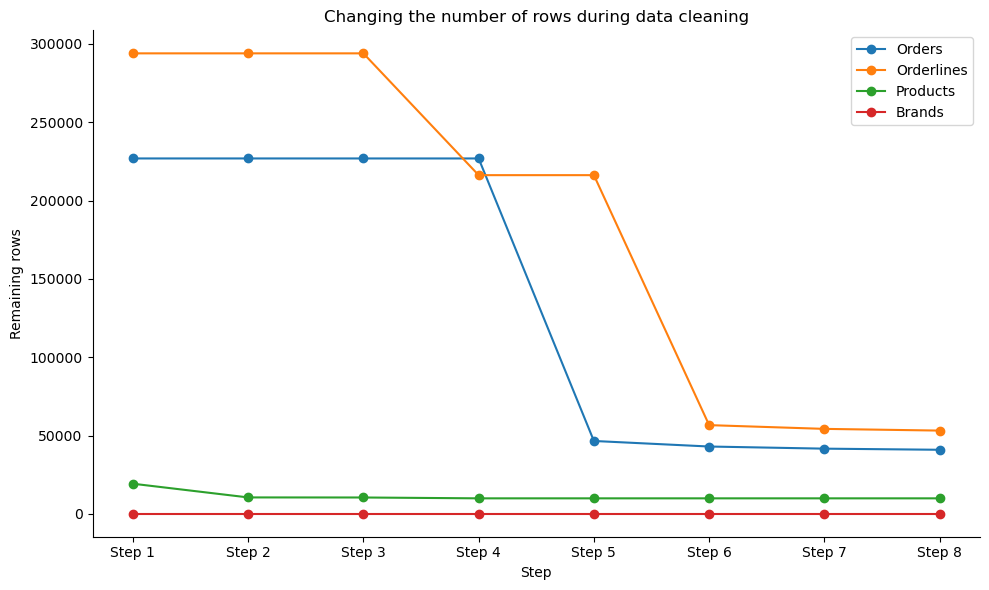

In [1]:
import matplotlib.pyplot as plt

# Data cleaning data
datasets = {
    'Orders': [226909, 226909, 226904, 226904, 46605, 43064, 41701, 40985],
    'Orderlines': [293983, 293983, 293983, 216250, 216250, 56714, 54324, 53231],
    'Products': [19326, 10580, 10534, 9992, 9992, 9992, 9992, 9992],
    'Brands': [187, 187, 187, 187, 187, 187, 187, 187]
}

plt.figure(figsize=(10, 6))
for dataset_name, values in datasets.items():
    plt.plot(range(1, len(values) + 1), values, marker='o', label=dataset_name)

plt.title('Changing the number of rows during data cleaning')
plt.xlabel('Step')
plt.ylabel('Remaining rows')
plt.xticks(range(1, 9), labels=[f"Step {i}" for i in range(1, 9)])
plt.legend()
plt.tight_layout()
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

# Save all changes in a CSV file

In [ ]:
# Saving a DataFrame as new .csv-file
# Example with options:
# dataframe.to_csv("dateiname.csv", sep=";", columns=['Name', 'City'], index=False, encoding='utf-8')

In [ ]:
# orders_cleaned.csv
o_df = o_df.to_csv('../data/cleaned/orders_cleaned.csv', index=False)

# orderlines_cleaned.csv
ol_df = ol_df.to_csv('../data/cleaned/orderlines_cleaned.csv', index=False)

# orderlines_cleaned.csv
p_df = p_df.to_csv('../data/cleaned/products_cleaned.csv', index=False)